In [48]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.image as im
import os 
import pandas as pd
import cv2
from skimage.color import rgb2gray
import math
from ImageGenerator import ImageDataGenerator, ImageAugmentation
from Preprocessing import EdgeDetection, Enhancement, Morphology
import pandas as pd
from skimage.feature import graycomatrix, graycoprops
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


## Data Loading

In [35]:
def display_sample(images, labels):
    plt.figure(figsize=(20,10))
    for i in range(7):
        plt.subplot(1,7,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap='gray')
        plt.xlabel(f"ID:{labels[i]}")
    plt.show()    

In [36]:
datagen = ImageDataGenerator()
images, labels = datagen.flow_from_directory(
    directory='Finger Dataset',
    target_size=(300,300),
    shuffle=True
)

Found 5910 images belonging to 5 classes.


In [37]:
images.shape, labels.shape

((5910, 300, 300, 3), (5910,))

<BarContainer object of 5 artists>

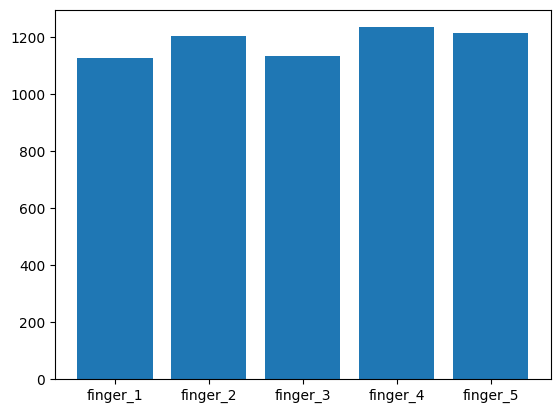

In [38]:
count_classes = np.unique(labels, return_counts=True)
plt.bar(count_classes[0], count_classes[1])

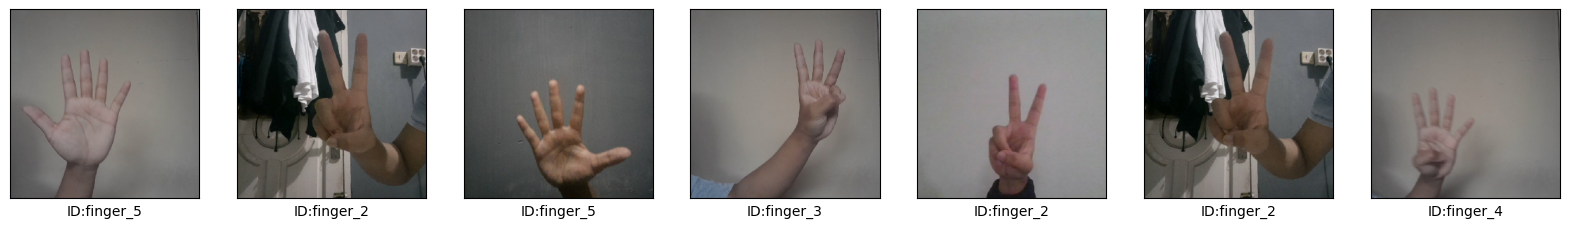

In [39]:
display_sample(images=images,labels=labels)

## Data Preparation

### Downsampling

In [40]:
def downsample(images, labels, n_samples):
    unique_labels = np.unique(labels)
    downsampled_images = []
    downsampled_labels = []
    for label in unique_labels:
        indices = np.where(labels == label)[0]
        selected_indices = np.random.choice(indices, n_samples, replace=True)
        downsampled_images.extend(images[selected_indices])
        downsampled_labels.extend(labels[selected_indices])
    
    return np.array(downsampled_images), np.array(downsampled_labels)

In [41]:
images, labels = downsample(images, labels, 100)

<BarContainer object of 5 artists>

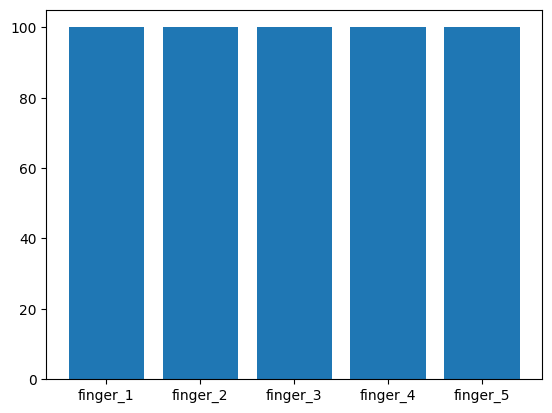

In [42]:
count_classes = np.unique(labels, return_counts=True)
plt.bar(count_classes[0], count_classes[1])

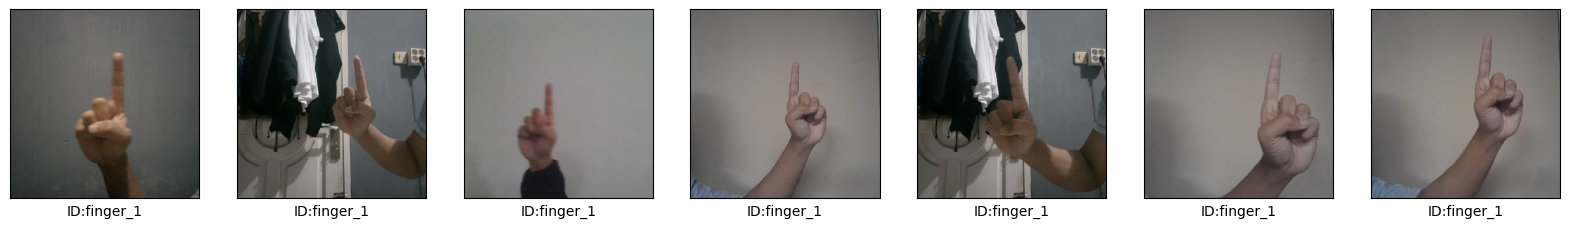

In [43]:
display_sample(images=images,labels=labels)

### Data Augmentation

In [44]:
augmentator = ImageAugmentation(
    rotation_range=40,
    height_shift_range=0.1,
    width_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.1,
) 

images, labels = augmentator.flow(images, labels, num_augmentations=6)

Generated 3500 augmented images.


In [45]:
images.shape, labels.shape

((3500, 300, 300, 3), (3500,))

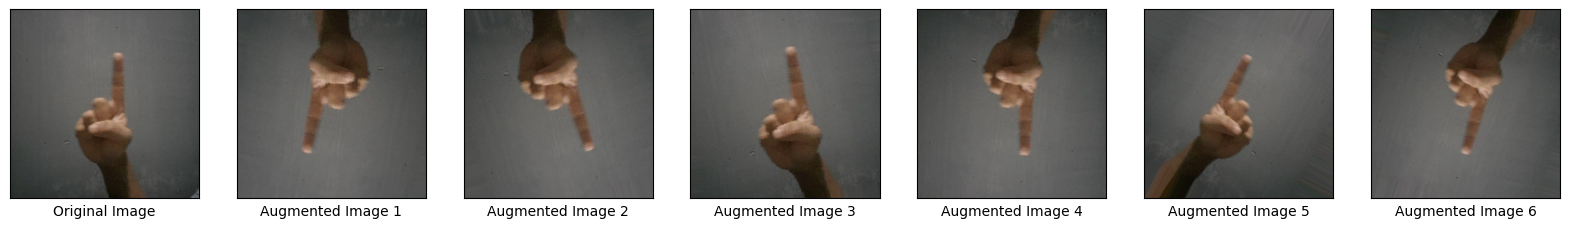

In [47]:
plt.figure(figsize=(20,10))
for i in range(7):
    plt.subplot(1,7,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap='gray')
    plt.xlabel('Original Image' if i == 0 else f"Augmented Image {i}")
plt.show()   

### Preprocessing

#### Skin Color Masking

Reference: [Human Skin Color Classification](https://medium.com/swlh/human-skin-color-classification-using-the-threshold-classifier-rgb-ycbcr-hsv-python-code-d34d51febdf8)

In [93]:
def skin_masking(images):
    skin_images = []
    for image in images:
        R_Frame = image[:,:,0]
        G_Frame = image[:,:,1]
        B_Frame = image[:,:,2]
        BRG_Max = np.maximum.reduce([B_Frame, G_Frame, R_Frame])
        BRG_Min = np.minimum.reduce([B_Frame, G_Frame, R_Frame])
        Rule_1 = np.logical_and.reduce([R_Frame > 50, G_Frame > 40, B_Frame > 20, BRG_Max - BRG_Min > 13, abs(R_Frame - G_Frame) > 10, R_Frame > G_Frame, R_Frame > B_Frame])
        Rule_2 = np.logical_and.reduce([R_Frame > 220, G_Frame > 210, B_Frame > 170, abs(R_Frame - G_Frame) <= 15, R_Frame > B_Frame, G_Frame > B_Frame])
        mask = np.logical_or(Rule_1, Rule_2)
        mask = mask.astype(np.uint8) * 255
        skin = cv2.bitwise_and(image, image, mask=mask)
        skin_images.append(skin)
    return np.array(skin_images)

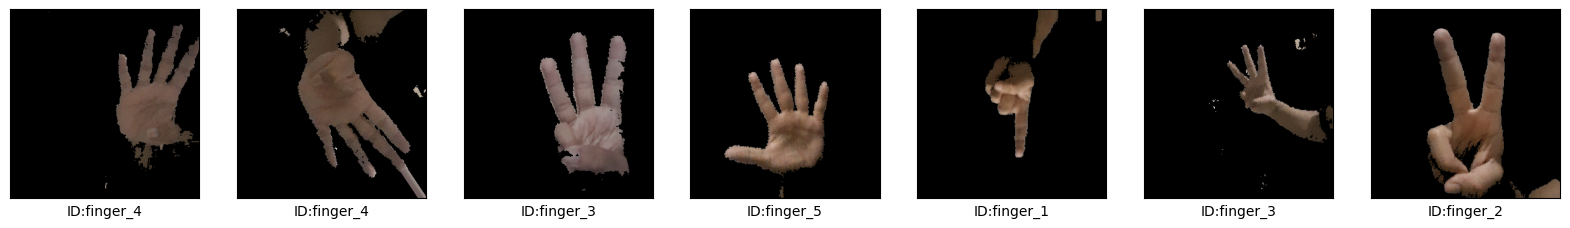

In [94]:
skin_images = skin_masking(images)
display_sample(images=skin_images,labels=labels)

#### Gray Scale

In [95]:
gray_images = [cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) for image in skin_images]
print(gray_images[0])

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


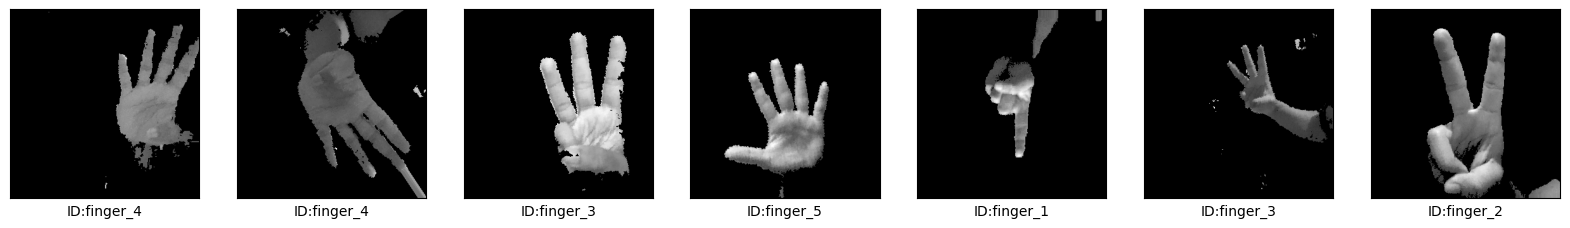

In [96]:
display_sample(images=gray_images,labels=labels)

#### Morphology

In [97]:
morphology = Morphology(kernel=np.ones((3,3), np.uint8), num_workers=8)

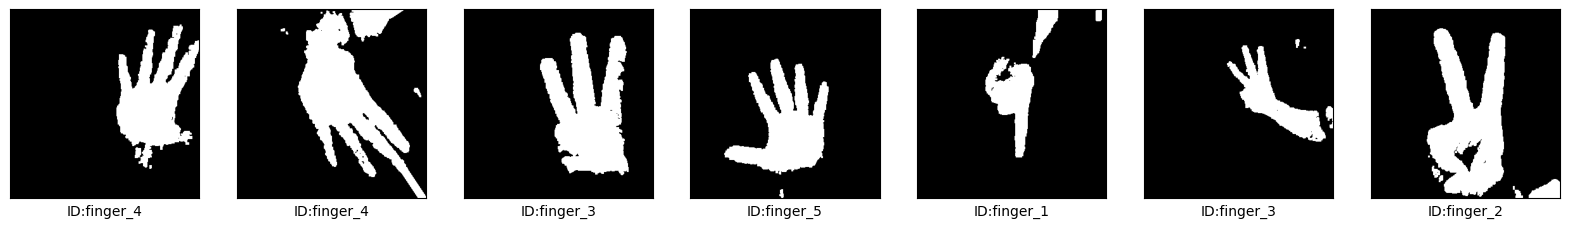

In [98]:
binary_mask = morphology.binary(images=gray_images, binary_threshold=1)
opening_mask = morphology.opening(images=binary_mask)
display_sample(images=opening_mask,labels=labels)

In [99]:
def apply_mask(images, masks):
    masked_images = []
    for image, mask in zip(images, masks):
        mask = mask.astype(np.uint8) * 255
        masked_image = cv2.bitwise_and(image, image, mask=mask)
        masked_images.append(masked_image)
    return masked_images

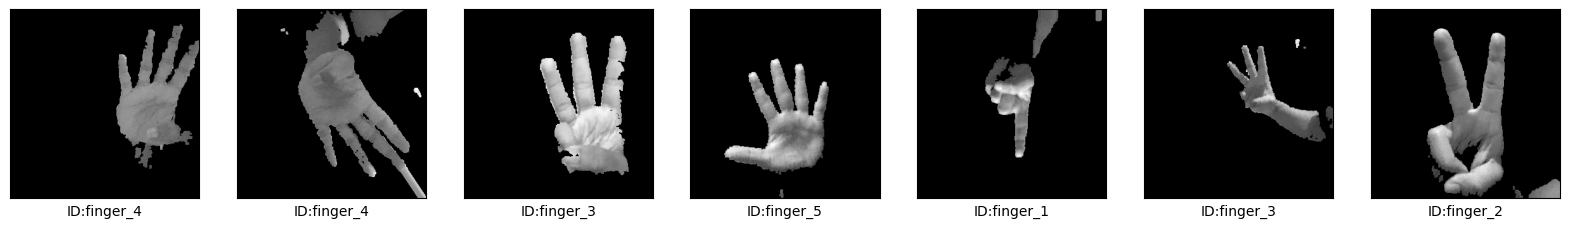

In [100]:
opening_images = apply_mask(gray_images, opening_mask)
display_sample(images=opening_images,labels=labels)

#### Enhancement

In [101]:
enhancer = Enhancement(num_workers=8)

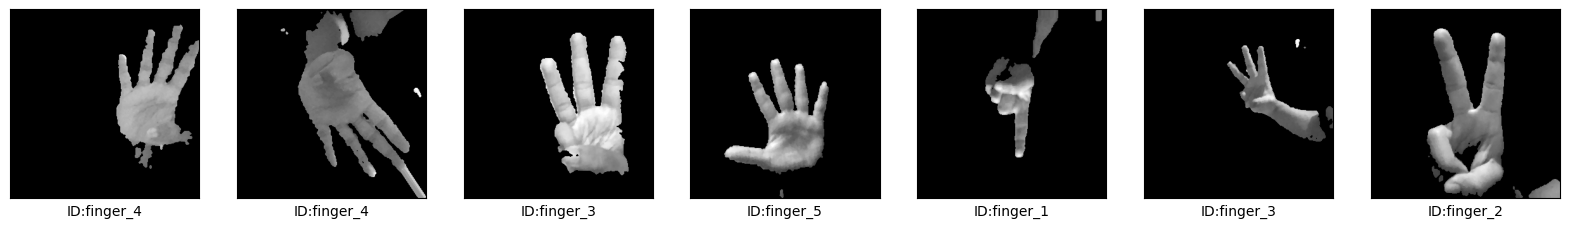

In [102]:
enhanced_images = enhancer.blur_images(blur_type='median', images=opening_images, kernel_size=3)
display_sample(images=enhanced_images,labels=labels)

#### Find Contours

In [103]:
def resize(image, size):
    height, width = image.shape[:2]
    new_height, new_width = size
    y_new, x_new = np.indices((new_height, new_width))
    y_new, x_new = (y_new * height // new_height).astype(int), (x_new * width // new_width).astype(int)
    image_resized = image[y_new, x_new]
    return image_resized

In [104]:
def find_contours(images):
    results = []
    for image in images:
        binary_image = np.where(image > 87, 255, 0).astype(np.uint8)
        rows, cols = np.nonzero(binary_image)
        min_row, min_col = np.min(rows), np.min(cols)
        max_row, max_col = np.max(rows), np.max(cols)
        cropped_image = image[min_row:max_row+1, min_col:max_col+1]
        resized_image = resize(cropped_image, (75, 75))
        results.append(resized_image)
    return results

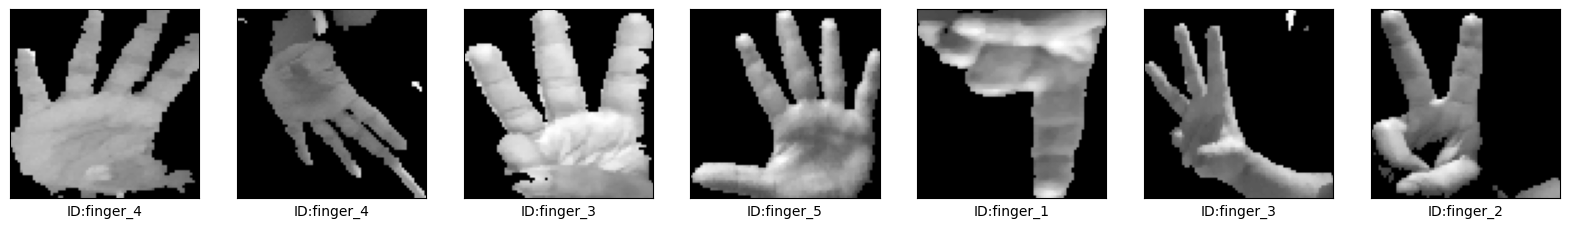

In [105]:
contours_images = find_contours(enhanced_images)
display_sample(images=contours_images,labels=labels)

### Features Extraction

In [106]:
dict_labels ={
    'finger_1' : 0,
    'finger_2' : 1,
    'finger_3' : 2,
    'finger_4' : 3,
    'finger_5' : 4,
}

In [107]:
def extract_glcm_features(images, labels, distances=[5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4], levels=256, symmetric=True, normed=True):
    features = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']
    angle_labels = ['0', '45', '90', '135']
    df_data = pd.DataFrame()
    for i, image in enumerate(images):
        image = image.astype(int)
        glcm = graycomatrix(image, distances, angles, levels, symmetric, normed)
        for feature in features:
            for angle, angle_label in zip(angles, angle_labels):
                feat_a = graycoprops(glcm, feature)[0, int(angle*4/np.pi)]
                df_data.loc[i, f'{feature}_{angle_label}'] = feat_a
        for angle, angle_label in zip(angles, angle_labels):
            asm = np.sum(glcm[:, :, 0, int(angle*4/np.pi)]**2)
            entropy = -np.sum(glcm[:, :, 0, int(angle*4/np.pi)]*np.log2(glcm[:, :, 0, int(angle*4/np.pi)] + np.finfo(float).eps))
            df_data.loc[i, f'asm_{angle_label}'] = asm
            df_data.loc[i, f'entropy_{angle_label}'] = entropy
        df_data.loc[i, 'label'] = dict_labels[labels[i]]
    return df_data

In [108]:
df_glcm = extract_glcm_features(contours_images, labels=labels)

In [109]:
df_glcm

,contrast_0,contrast_45,contrast_90,contrast_135,dissimilarity_0,dissimilarity_45,dissimilarity_90,dissimilarity_135,homogeneity_0,homogeneity_45,...,correlation_135,asm_0,entropy_0,asm_45,entropy_45,asm_90,entropy_90,asm_135,entropy_135,label
0,1768.320952,1930.804999,1137.489905,1365.584606,23.408952,26.309066,17.052571,19.286253,0.358650,0.291555,...,0.604250,0.063717,7.732198,0.050296,8.081334,0.088581,7.687207,0.070051,7.888678,3.0
1,1812.106476,962.718707,1484.389905,2024.235469,21.899238,13.042055,17.873333,24.230708,0.553610,0.616566,...,0.373513,0.273481,5.519998,0.323768,5.276858,0.315946,5.237368,0.259917,5.575754,3.0
2,3105.920381,2531.586193,1792.079048,3266.372942,31.926476,28.332077,21.813905,34.587582,0.291026,0.305981,...,0.487873,0.060900,8.801246,0.069178,8.836806,0.099234,8.447755,0.056196,8.908830,2.0
3,3368.077524,3385.628050,2257.855238,3732.729022,34.036000,35.312636,25.453714,38.123587,0.383712,0.381870,...,0.414587,0.128828,7.933115,0.134717,8.002267,0.177535,7.614807,0.119482,8.071418,4.0
4,1494.007619,1901.003769,1564.364952,1991.394366,18.807619,24.932751,20.617524,24.786947,0.459871,0.437812,...,0.677922,0.170954,7.475274,0.178092,7.519773,0.222201,7.048745,0.176254,7.528260,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1495,2915.558286,2512.483436,2828.052381,3415.882365,32.668000,28.742511,30.419238,35.599484,0.427807,0.445465,...,0.455198,0.169763,7.427128,0.185163,7.412398,0.182468,7.336610,0.143449,7.608254,4.0
1496,2265.568952,2353.419560,1981.428571,2746.009919,28.734667,30.464987,26.197714,34.063083,0.341025,0.336466,...,0.496240,0.099170,8.553041,0.098464,8.680280,0.121093,8.376088,0.081710,8.822832,2.0
1497,1692.028381,1972.266217,1028.182857,1342.101964,21.751048,24.869272,13.146286,16.974013,0.560438,0.536114,...,0.577023,0.283709,5.300273,0.267810,5.353543,0.353502,4.933005,0.320781,5.144851,3.0
1498,1271.370476,1979.394366,1488.928571,804.489189,16.409333,25.994247,20.901905,13.352906,0.416621,0.323022,...,0.784623,0.111788,7.947054,0.083978,8.346075,0.110521,8.037812,0.116250,7.951858,0.0


In [88]:
# df_glcm.to_csv('glcm_features_small.csv', index=False)
df_glcm = pd.read_csv('glcm_features.csv')



In [89]:
# df_glcm.head(10).drop(columns=['label']).to_csv('validation.csv', index=False)
# df_glcm['label'].head(10).to_csv('validation_labels.csv', index=False)

### Dimensionality Reduction

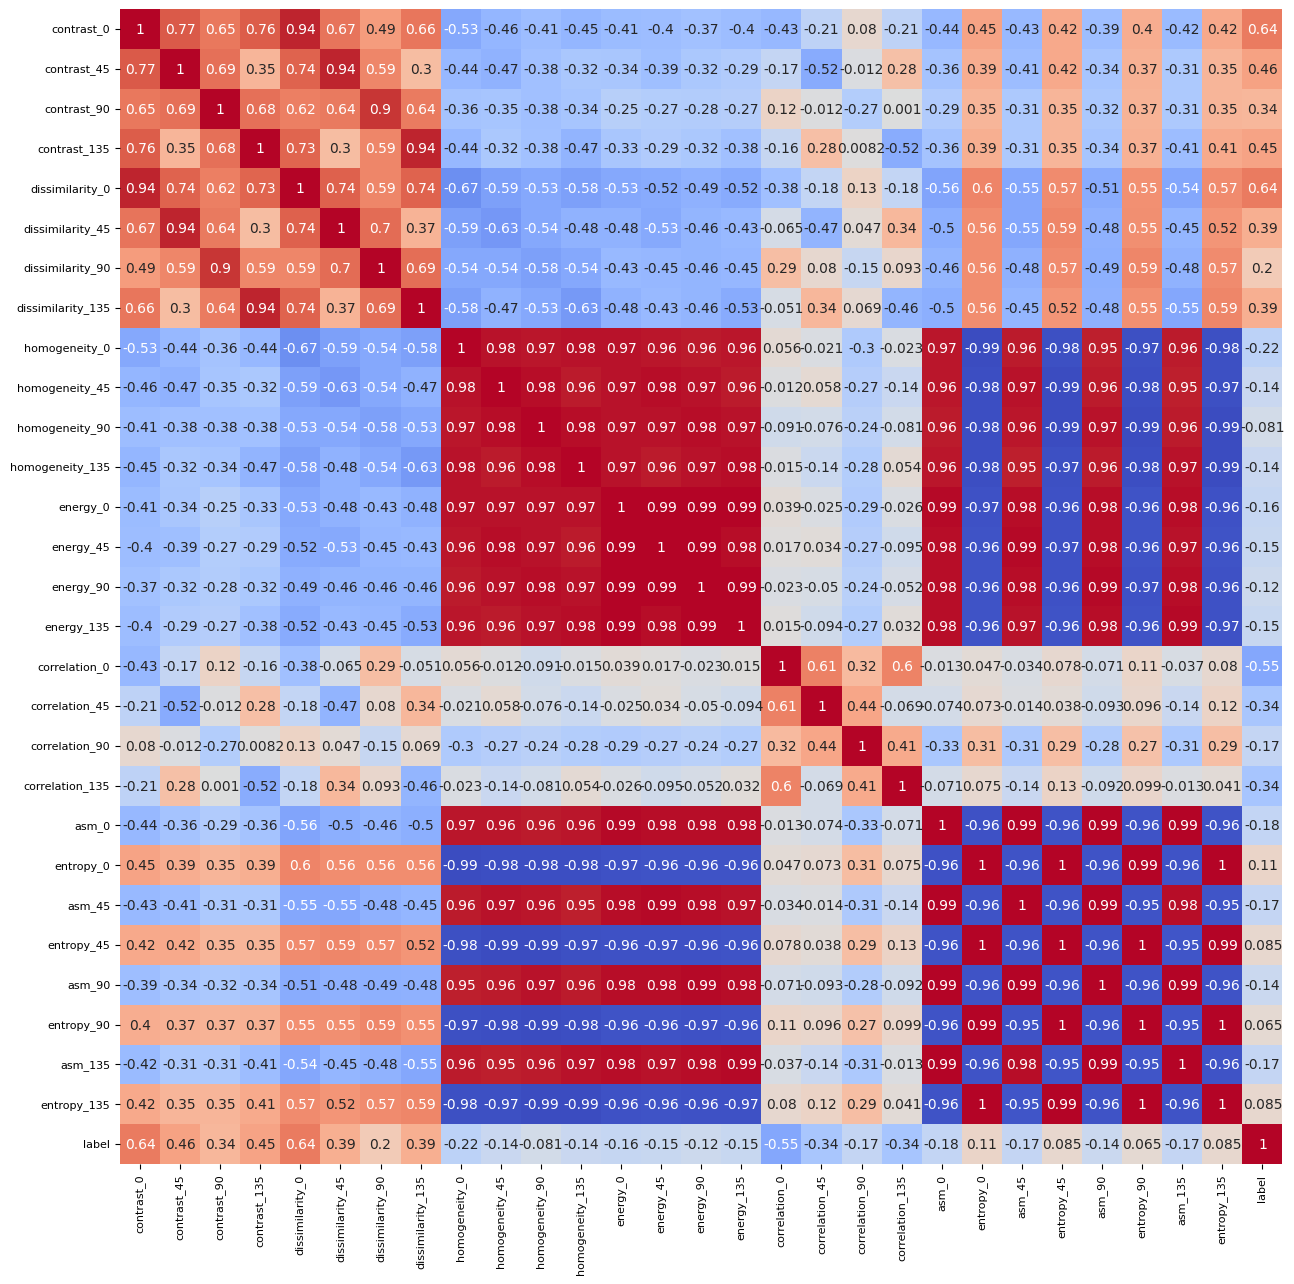

In [90]:
corr_glcm = df_glcm.corr()  
plt.figure(figsize=(15,15))
sns.heatmap(corr_glcm, annot=True, cmap='coolwarm', cbar=False)
plt.tick_params(axis='both', which='major', labelsize=8)
plt.tick_params(axis='both', which='minor', labelsize=8)
plt.show()

In [91]:
x, y = df_glcm.drop('label', axis=1), df_glcm['label']

In [102]:
pca = PCA(n_components=25)
x_pca = pca.fit_transform(x)

### Splitting Data

In [103]:
x_train, x_test, y_train, y_test = train_test_split(x_pca, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((12000, 25), (3000, 25), (12000,), (3000,))

### Normalization

In [104]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)


## Modeling

### KNN Classifier

In [105]:
knn = KNeighborsClassifier(n_neighbors=1, metric='cosine')
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9486666666666667


### SVM Classifier

In [106]:
svm = SVC(kernel='rbf', C=30, gamma='auto')
svm.fit(x_train, y_train)
y_pred = svm.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9763333333333334


### Random Forest Classifier

In [107]:
rfc = RandomForestClassifier(n_estimators=500, class_weight='balanced', n_jobs=-1, max_depth=50, min_samples_leaf=1, min_samples_split=2, bootstrap=False, criterion='gini')
rfc.fit(x_train, y_train)
y_pred = rfc.predict(x_test)
print('Accuracy:', accuracy_score(y_test, y_pred))

Accuracy: 0.9586666666666667


## Evaluation

In [108]:
model_dict = {
    'KNN': knn,
    'SVM': svm,
    'RF': rfc
}
df_eval = pd.DataFrame(columns=['Accuracy', 'Precision', 'Recall', 'F1 Score'], index=model_dict.keys())


In [109]:
for model_name, model in model_dict.items():
    y_pred = model.predict(x_test)
    df_eval.loc[model_name, 'Accuracy'] = accuracy_score(y_test, y_pred)
    df_eval.loc[model_name, 'Precision'] = precision_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'Recall'] = recall_score(y_test, y_pred, average='weighted')
    df_eval.loc[model_name, 'F1 Score'] = f1_score(y_test, y_pred, average='weighted')
    

In [110]:
df_eval

,Accuracy,Precision,Recall,F1 Score
KNN,0.948667,0.948664,0.948667,0.948504
SVM,0.976333,0.976319,0.976333,0.976315
RF,0.958667,0.95894,0.958667,0.958635


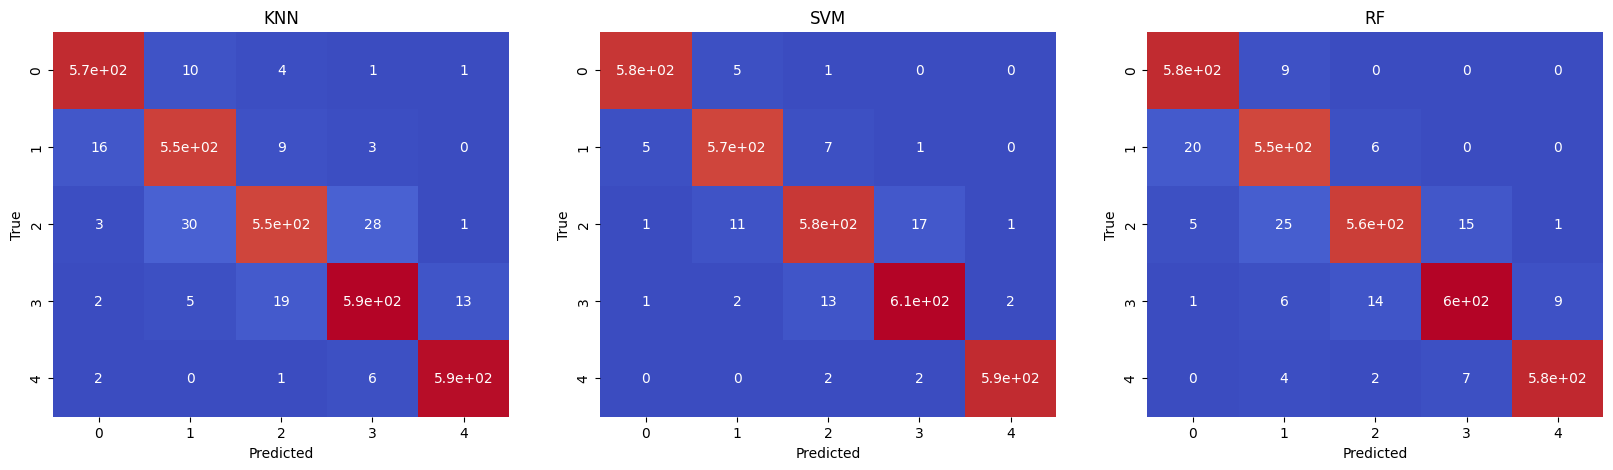

In [111]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))
for i, model_name in enumerate(model_dict.keys()):
    y_pred = model_dict[model_name].predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, cmap='coolwarm', cbar=False, ax=ax[i])
    ax[i].set_xlabel('Predicted')
    ax[i].set_ylabel('True')
    ax[i].set_title(model_name)
plt.show()